🔹 INPUT PARAMETERS
Target Phase (φ): 0.125
Counting Qubits : 4
Shots           : 1024


🧩 VIEW 1: Quantum Circuit



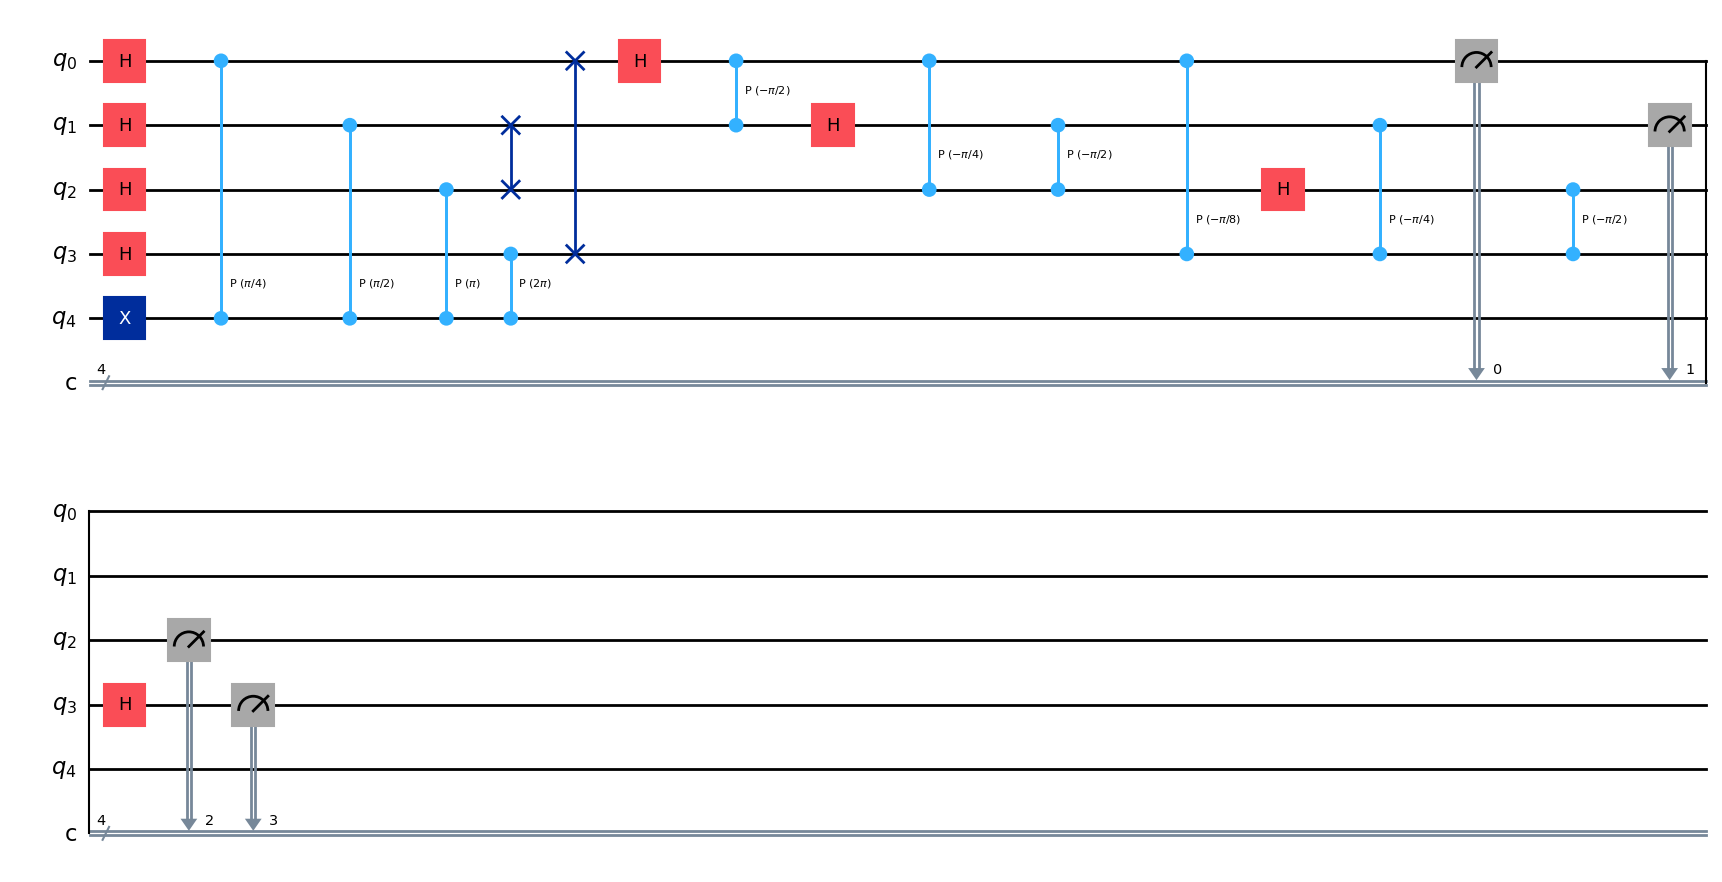


📊 VIEW 2: Measurement Probability Distribution



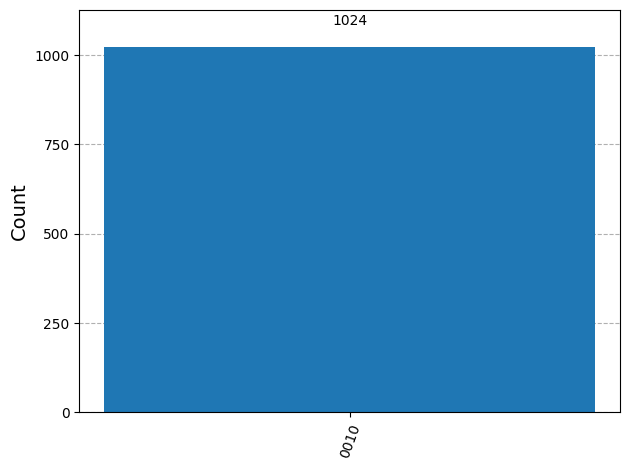


🔢 VIEW 3: Binary Phase Interpretation
Measured Binary : 0010
Estimated Phase : 0.125000

📐 VIEW 4: Estimation Error Analysis
Actual Phase    : 0.125
Estimated Phase : 0.125000
Absolute Error  : 0.000000


In [8]:
# ==========================================================
# Quantum Phase Estimation
# ==========================================================

!pip install qiskit qiskit-aer ipywidgets matplotlib pylatexenc --quiet

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# ----------------------------------------------------------
# Inverse QFT
# ----------------------------------------------------------
def inverse_qft(n):
    qc = QuantumCircuit(n)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)
    return qc

# ----------------------------------------------------------
# Build QPE Circuit
# ----------------------------------------------------------
def build_qpe(phase, n_count):
    qc = QuantumCircuit(n_count + 1, n_count)

    # Eigenstate |1⟩
    qc.x(n_count)

    # Superposition
    for q in range(n_count):
        qc.h(q)

    # Controlled-U
    for q in range(n_count):
        qc.cp(2 * np.pi * phase * (2 ** q), q, n_count)

    # Inverse QFT
    qc = qc.compose(inverse_qft(n_count), range(n_count))

    # Measurement
    qc.measure(range(n_count), range(n_count))

    return qc

# ----------------------------------------------------------
# Run Analysis
# ----------------------------------------------------------
def run_qpe_analysis(phase, n_qubits, shots):
    clear_output(wait=True)

    print("🔹 INPUT PARAMETERS")
    print(f"Target Phase (φ): {phase}")
    print(f"Counting Qubits : {n_qubits}")
    print(f"Shots           : {shots}")
    print("\n")

    qc = build_qpe(phase, n_qubits)

    # --- View 1: Circuit ---
    print("🧩 VIEW 1: Quantum Circuit\n")
    display(qc.draw("mpl"))

    # Simulation
    sim = AerSimulator()
    result = sim.run(qc, shots=shots).result()
    counts = result.get_counts()

    # --- View 2: Histogram ---
    print("\n📊 VIEW 2: Measurement Probability Distribution\n")
    display(plot_histogram(counts))

    # --- View 3: Binary Interpretation ---
    most_likely = max(counts, key=counts.get)
    estimated_phase = int(most_likely, 2) / (2 ** n_qubits)

    print("\n🔢 VIEW 3: Binary Phase Interpretation")
    print(f"Measured Binary : {most_likely}")
    print(f"Estimated Phase : {estimated_phase:.6f}")

    # --- View 4: Error Analysis ---
    error = abs(phase - estimated_phase)

    print("\n📐 VIEW 4: Estimation Error Analysis")
    print(f"Actual Phase    : {phase}")
    print(f"Estimated Phase : {estimated_phase:.6f}")
    print(f"Absolute Error  : {error:.6f}")

# ----------------------------------------------------------
# UI Controls (INPUT PANEL)
# ----------------------------------------------------------
phase_input = widgets.FloatText(
    value=0.125,
    description="Phase φ:",
    style={'description_width': 'initial'}
)

qubits_input = widgets.IntSlider(
    value=4, min=2, max=6, step=1,
    description="Counting Qubits"
)

shots_input = widgets.IntSlider(
    value=1024, min=256, max=4096, step=256,
    description="Shots"
)

run_btn = widgets.Button(
    description="Run Phase Estimation",
    button_style="success"
)

def on_run(b):
    run_qpe_analysis(
        phase_input.value,
        qubits_input.value,
        shots_input.value
    )

run_btn.on_click(on_run)

# ----------------------------------------------------------
# UI Layout (UX FLOW)
# ----------------------------------------------------------
display(
    widgets.VBox([
        widgets.HTML("<h2 style='text-align:center;'>⚛️ Quantum Phase Estimation </h2>"),
        widgets.HTML("<b>Step 1:</b> Enter the unknown phase (φ ∈ [0,1])"),
        phase_input,
        widgets.HTML("<b>Step 2:</b> Choose number of counting qubits"),
        qubits_input,
        widgets.HTML("<b>Step 3:</b> Select number of measurements"),
        shots_input,
        widgets.HTML("<b>Step 4:</b> Execute and analyze results"),
        run_btn
    ])
)
